# Forest Fire Detection with transfer learning using Xception

In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras.models import load_model
from keras.applications import VGG16
from keras import layers
from keras import Model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#train_dir = "/content/gdrive/My Drive/Escuela/Octavo Semestre/Fire_Original/Training"
#test_dir = "/content/gdrive/My Drive/Escuela/Octavo Semestre/Fire_Original/Test"

train_dir = "data/Training"
test_dir = "data/Test"

VGG_SIZE = 224

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.1,
                                horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                target_size=(VGG_SIZE, VGG_SIZE), 
                                                color_mode='rgb',
                                                batch_size=20,
                                                class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                target_size=(VGG_SIZE, VGG_SIZE),
                                                color_mode='rgb',
                                                batch_size=20,
                                                class_mode='binary')

Found 39395 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [5]:
transfer_model = VGG16(include_top=True,
                        weights="imagenet",
                        classes=1000)
input = transfer_model.inputs

553467904/553467096 [==============================] - 58s 0us/step


In [6]:
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
x = transfer_model.get_layer("block5_pool").output
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(2048, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

classifier = Model(input, output_layer)

for layer in classifier.layers[:-3]:
    layer.trainable = False

classifier.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [10]:
classifier.compile(loss="binary_crossentropy",
                optimizer=optimizers.Adam(lr=0.001),
                metrics=["accuracy"])

In [11]:
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    ModelCheckpoint(filepath='models/vgg16_model.h5', save_best_only=True, monitor='val_accuracy'),
]

history = classifier.fit(train_generator, 
                        epochs=5, 
                        batch_size=40,
                        validation_data=test_generator,
                        callbacks=callbacks)

Epoch 1/5
1970/1970 [==============================] - 599s 300ms/step - loss: 0.1662 - accuracy: 0.9698 - val_loss: 1.4665 - val_accuracy: 0.7200
Epoch 2/5
1970/1970 [==============================] - 598s 304ms/step - loss: 0.0213 - accuracy: 0.9930 - val_loss: 1.6466 - val_accuracy: 0.6926
Epoch 3/5
1970/1970 [==============================] - 573s 291ms/step - loss: 0.0210 - accuracy: 0.9928 - val_loss: 1.4813 - val_accuracy: 0.6958
Epoch 4/5
1970/1970 [==============================] - 571s 290ms/step - loss: 0.0127 - accuracy: 0.9962 - val_loss: 1.4029 - val_accuracy: 0.6790


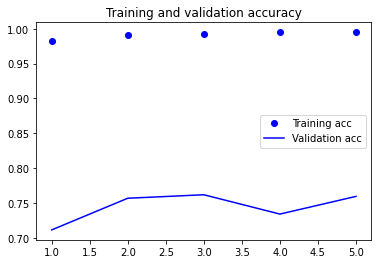

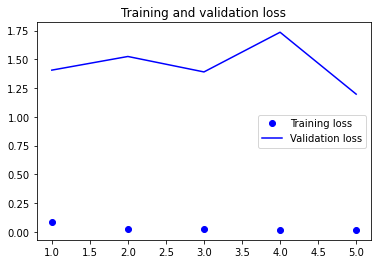

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [13]:
result = classifier.evaluate(test_generator)
print(f"Test loss: {result[0]}, Test accuracy: {result[1]}")

431/431 [==============================] - 82s 190ms/step - loss: 1.5786 - accuracy: 0.7660
Test loss: 1.5786386728286743, Test accuracy: 0.7660438418388367


In [6]:
from keras import models

#model_path = "/content/gdrive/My Drive/Escuela/Octavo Semestre/DSDM/models/vgg19_model_best.h5"
model_path = 'models/vgg19_model.h5'

model = models.load_model(model_path)
result = model.evaluate(test_generator)
print(f"Test loss: {result[0]}, Test accuracy: {result[1]}")

431/431 [==============================] - 90s 195ms/step - loss: 1.0949 - accuracy: 0.7313
Test loss: 1.094875454902649, Test accuracy: 0.731344997882843
